## Visual Analysis

In [1]:
%%capture
import math
import pickle
import matplotlib
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
from scipy.stats import ttest_1samp
from datetime import timedelta, datetime, time, date
from matplotlib import rc
from tqdm.notebook import tqdm
from cycler import cycler
tqdm().pandas()

color_list = ["#348ABD","#A60628","#7A68A6","#467821","#CF4457","#188487","#E24A33"]
style = {
  "lines.linewidth": 2.0,
  "axes.edgecolor": "#bcbcbc",
  "patch.linewidth": 0.5,
  "legend.fancybox": True,
  "axes.prop_cycle": cycler('color', color_list),
  "axes.facecolor": "#ffffff",
  "axes.labelsize": "large",
  "axes.grid": True,
  "patch.edgecolor": "#eeeeee",
  "axes.titlesize": "x-large",
  "svg.fonttype": "path"}

matplotlib.rcParams.update(style)

# Modify pandas display settings
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 30)

data_path    = "C:/Users/Stefa/Documents/Uni/Projektassistenz/Python/Data/"
output_path  = "./Auswertung/"
extended_model_path = data_path+"Classification/DagoBERT/SCE_Loss_minw_25_lr_5e5_3ep_bs32_wd_1e2_a0_5_b3_NN1_w2v_topics/"

def t_test(sample, parent):
    mu = np.mean(parent)
    t_value = (np.mean(sample)-mu)/(np.std(sample)/np.sqrt(sample.shape[0]))
    return t_value  


def cal_metric(metric='mean', setting='Conditional_1'):
    if setting == 'neg_sentiment':
        label = 'Negative sentiment'
    elif setting == 'pos_sentiment':
        label = 'Positive sentiment'
    else:
        label = re.sub(r'_', ' ', setting)
    var = table[setting].loc[metric]*10000
        
    return var, label

  
    
    
ylabel_dict = {'mo_to_mc':'(open$_{(t)}$ to close$_{(t)}$)',
               'mc_to_mo':'(close$_{(t-1)}$ to open$_{(t)}$)',
               'mo_to_mo':'(open$_{(t)}$ to open$_{(t+1)}$)'}


def export_plot(table, idiosyncratic=False, show_standard_error=True, 
                yscale=0.75, export=False, title=None,
                xlabel=None, ylabel=None,
                filename=datetime.now().strftime("%m%d%Y_%Hh%Mm%Ss")):    
    
    
    
    fontsize = 12
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': fontsize})
    rc('text', usetex=True)

    # linestyles
    col  = ["#348ABD", "#A60628", "#7A68A6"]
    line = ["dashed", "dashdot", "solid"]

    axes  = {}
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    
    mean_0       = table['z_score_no_news'].loc['mean']*10000
    std_error_0  = table['z_score_no_news'].loc['std_error']*10000

    mean_1, label_1 = cal_metric(metric='mean',      setting='neg_sentiment')
    mean_2, label_2 = cal_metric(metric='mean',      setting='pos_sentiment')               
    std_error_1, _  = cal_metric(metric='std_error', setting='neg_sentiment')
    std_error_2, _  = cal_metric(metric='std_error', setting='pos_sentiment')
    
    above_line_0 = (mean_0.values+std_error_0.values).astype(np.float32)
    below_line_0 = (mean_0.values-std_error_0.values).astype(np.float32)
    above_line_1 = (mean_1.values+std_error_1.values).astype(np.float32)
    below_line_1 = (mean_1.values-std_error_1.values).astype(np.float32)
    above_line_2 = (mean_2.values+std_error_2.values).astype(np.float32)
    below_line_2 = (mean_2.values-std_error_2.values).astype(np.float32)


    ax.plot(mean_1, label=label_1, linestyle='dashed', linewidth=1.5, color=col[0])
    ax.plot(mean_2, label=label_2, linestyle='dashdot', linewidth=1.5, color=col[1])
    ax.plot(mean_0, label='Without news events', linewidth=1.5, color=col[2])
    if show_standard_error:
        ax.fill_between(mean_1.index, above_line_1, below_line_1, color='b', alpha=.1) 
        ax.fill_between(mean_2.index, above_line_2, below_line_2, color='r', alpha=.1) 
        ax.fill_between(mean_0.index, above_line_0, below_line_0, color='k', alpha=.1) 

    ax.set_xlabel('z-score', labelpad=15)
    #ax.set_ylabel('Avg. daily return (in %)')
    ax.set_ylim([-yscale,yscale])
    ax.set_xlim([-2,2])
    ax.set_xticks(ax.get_xticks(), ['$< -2.0$', '$< -1.5$', '$< -1.0$', '$< -0.5$', '0', '$> 0.5$', '$> 1.0$', '$> 1.5$', '$> 2.0$'])
    ax.legend()
    if title != None:
        ax.set_title(title)
    if xlabel != None:
        ax.set_xlabel(xlabel)
    if ylabel != None:
        ax.set_ylabel(ylabel)
    if export:
        plt.savefig(output_path+'plots/'+filename+'_'+datetime.now().strftime("%Hh%Mm%Ss")+'.pdf', bbox_inches='tight')
    plt.show()

### 1. Simple Case  
We look at the z-score of the previous close (t-1), analyze overnight news and observe the close-to-open (overnight) return and the open-to-close (daytime) return on day t.

In [6]:
class Strategy():    
    def __init__(self, return_period, freshness, sel_topics=[], use_abnormal_returns=True): 
        self.freshness  = freshness
        abn = '_abn' if use_abnormal_returns else '' 
        self.isfresh = '_freshness' if type(freshness) == str else ''
        self.event_data = pd.read_csv(f'./Data/event_data{abn}_returns_{return_period}_17_5h_z_val_idiosync_no_dupl{self.isfresh}_2002-2021_v2.csv', encoding='utf-8')
        self.event_data.Date = pd.to_datetime(self.event_data.Date)
        self.event_data = self.event_data.set_index(['Date', 'Ticker'])
        
        if type(freshness) == float:
            self.event_data['freshness'] = np.nan
        
        self.vix = pd.read_csv("C:/Users/Stefa/Documents/Uni/Projektassistenz/Financial Data/VIX.csv", encoding="utf-8")
        self.vix.date = pd.to_datetime(self.vix.date)
        self.vix = self.vix.set_index('date')
        

    def neg_sentiment(self, z_score, r='return_t'):                    
        # Negative news on day t and significantely negative z-value on day t-1 at market close ---------------
        neg_z = self.data.loc[self.filter_topics    &
                              self.filter_freshness & 
                              (self.data.Sentiment <= -self.barrier) &
                              (self.data.z_value   <= -z_score), r].reset_index(drop=True)

        # Negative news on day t and significantely positive z-value on day t-1 at market close ---------------
        pos_z = self.data.loc[self.filter_topics    &
                              self.filter_freshness & 
                              (self.data.Sentiment <= -self.barrier) &
                              (self.data.z_value   >= z_score), r].reset_index(drop=True)       
        
        self.strategy_df = pd.concat([neg_z, pos_z], axis=1)
        self.strategy_df.columns = ['neg_z_score', 'pos_z_score']
        
        
        
    def pos_sentiment(self, z_score, r='return_t'):          
        # Positive news on day t and significantely negative z-value on day t-1 at market close --------------
        neg_z = self.data.loc[self.filter_topics    &
                              self.filter_freshness & 
                              (self.data.Sentiment >= self.barrier) &
                              (self.data.z_value   <= -z_score), r].reset_index(drop=True)        
        
        # Positive news on day t and significantely positive z-value on day t-1 at market close --------------
        pos_z = self.data.loc[self.filter_topics    &
                              self.filter_freshness & 
                              (self.data.Sentiment >= self.barrier) &
                              (self.data.z_value   >= z_score), r].reset_index(drop=True)
        
        
        self.strategy_df = pd.concat([neg_z, pos_z], axis=1)
        self.strategy_df.columns = ['neg_z_score', 'pos_z_score']
        
        
       
    def z_score_no_news(self, z_score, r='return_t'):                  
        # Negative z-value on day t-1 at market close ---------------
        neg_z = self.data.loc[(self.data.z_value <= -z_score) & (self.data.Sentiment.isna()), r].dropna().reset_index(drop=True)
        
        # Positive z-value on day t-1 at market close ---------------
        pos_z = self.data.loc[(self.data.z_value >=  z_score) & (self.data.Sentiment.isna()), r].dropna().reset_index(drop=True)
        
        self.strategy_df = pd.concat([neg_z, pos_z], axis=1)
        self.strategy_df.columns = ['neg_z_score', 'pos_z_score']

                
        
    def fill_table(self, table, z_score, setting):
        table[setting].loc['mean', -z_score] = self.strategy_df['neg_z_score'].dropna().mean()
        table[setting].loc['mean',  z_score] = self.strategy_df['pos_z_score'].dropna().mean()                
        table[setting].loc['sd',   -z_score] = self.strategy_df['neg_z_score'].dropna().std()
        table[setting].loc['sd',    z_score] = self.strategy_df['pos_z_score'].dropna().std()                
        table[setting].loc['std_error', -z_score] = self.strategy_df['neg_z_score'].dropna().std()/np.sqrt(self.strategy_df['neg_z_score'].dropna().shape[0])
        table[setting].loc['std_error',  z_score] = self.strategy_df['pos_z_score'].dropna().std()/np.sqrt(self.strategy_df['pos_z_score'].dropna().shape[0])               
        table[setting].loc['t_value',   -z_score] = ttest_1samp(self.strategy_df['neg_z_score'].dropna(), 0)[0]
        table[setting].loc['t_value',    z_score] = ttest_1samp(self.strategy_df['pos_z_score'].dropna(), 0)[0]             
        table[setting].loc['n_obs',     -z_score] = self.strategy_df['neg_z_score'].dropna().shape[0]
        table[setting].loc['n_obs',      z_score] = self.strategy_df['pos_z_score'].dropna().shape[0]               
        return table
        
        
        
    def calc_stats(self, period_start, period_end, settings, sel_topics, min_vix=0, max_vix=100, senti_limit=0.95,
                   z_scores = [0.0001, 0.2, 0.4, 0.6, 0.8, 1.0, 1.25, 1.5, 1.645, 1.96]):        
        
        self.barrier = senti_limit 
            
        # Filter Dates    
        self.data = self.event_data.loc[((self.event_data.index.get_level_values(0) > period_start) &
                                         (self.event_data.index.get_level_values(0) < period_end)), :]                
                
        # Filter for Volatility
        volatile_dates = self.vix.loc[((self.vix.vix >= min_vix) & (self.vix.vix < max_vix))].index
        self.data = self.data.loc[self.data.index.get_level_values(0).isin(volatile_dates)] 
                 
        # Filter topics
        self.filter_topics = ((self.data.Sentiment.isna()) | 
                              ((self.data.topic_1 >= sel_topics['topic_1']) &
                               (self.data.topic_2 >= sel_topics['topic_2']) &
                               (self.data.topic_3 >= sel_topics['topic_3']) &
                               (self.data.topic_4 >= sel_topics['topic_4'])))
           
        # Filter freshness
        if type(self.freshness) == str:
            self.filter_freshness = (self.data.freshness == self.freshness)
        else:
            self.filter_freshness = self.data.freshness.isna()
            
            
        table = {}
        for setting in settings:
            table[setting] = pd.DataFrame(columns=[-z_scores[i] for i in range(len(z_scores)-1,-1,-1)]+z_scores)
            table[setting].index.name = 'Variable'
            
            for z_score in z_scores:
                if setting == 'neg_sentiment':
                    self.neg_sentiment(z_score)
                elif setting == 'pos_sentiment':
                    self.pos_sentiment(z_score)
                elif setting == 'z_score_no_news':
                    self.z_score_no_news(z_score)                         
                table = self.fill_table(table, z_score, setting)

        return table
    

return_period = 'mc_to_mo'

S = Strategy(return_period,
             freshness  = 'fresh',   # np.nan, 'fresh', 'stale'
             sel_topics = [], 
             use_abnormal_returns = True)   

In [7]:
table = S.calc_stats(period_start = datetime(2002,1,1), 
                     period_end   = datetime(2019,12,31),
                     min_vix      = 0,
                     max_vix      = 200,
                     senti_limit  = 0.45,                                                          # Consider all news with a predicted sentiment >= senti_limit
                     sel_topics   = {'topic_1':0.0, 'topic_2':0.0, 'topic_3':0.0, 'topic_4':0.0},
                     settings     = ['neg_sentiment', 'pos_sentiment', 'z_score_no_news'])

In [8]:
for i, setting in enumerate(['z_score_no_news', 'neg_sentiment', 'pos_sentiment']):
    temp_df = table[setting].loc[:, [-1.645, -1.5, -1, -0.2, 0.2, 1, 1.5, 1.645]]
    temp_df.loc[['mean', 'sd', 'std_error']] = temp_df.loc[['mean', 'sd', 'std_error']]*10000
    temp_df.loc[['mean', 'sd', 'std_error', 't_value']] = temp_df.T.loc[:, ['mean', 'sd', 'std_error', 't_value']].astype('float').round(2).T
    temp_df['Class'] = setting
    if i == 0:
        export_table = temp_df   
    else:
        export_table = pd.concat([export_table, temp_df], axis=0)

export_table = export_table.reset_index().set_index(['Class', 'Variable'])
export_table

-1.645    -1.5    -1.0    -0.2     0.2     1.0  \
Class           Variable                                                    
z_score_no_news mean         3.89    3.54    2.72    2.36    1.87    2.49   
                sd         147.12  141.49   118.0   97.97   95.51  111.43   
                std_error    0.49    0.42    0.23    0.11    0.11    0.22   
                t_value      7.87    8.43   11.75   21.64   17.33   11.34   
                n_obs       88811  113220  258936  807094  782660  258522   
neg_sentiment   mean       -92.53  -90.07  -94.31 -101.14   -89.8  -75.31   
                sd         494.25  478.94  434.33  417.22  417.38  445.34   
                std_error   11.34   10.07    6.85    4.26    4.54    7.74   
                t_value     -8.16   -8.94  -13.77  -23.72  -19.78   -9.73   
                n_obs        1900    2260    4020    9573    8455    3308   
pos_sentiment   mean        83.52   80.62   91.07   93.26   92.36   88.22   
                sd         345.69  352.26  341.41   329.0  334.41  350.15   
                std_error    9.17    8.51    5.76    3.35    3.27    5.38   
                t_value      9.11    9.48   15.81   27.83   28.21    16.4   
                n_obs        1421    1714    3511    9639   10433    4238   

                              1.5   1.645  
Class           Variable                   
z_score_no_news mean          3.7    4.32  
                sd         127.07  130.36  
                std_error    0.37    0.43  
                t_value      9.95   10.09  
                n_obs      116786   92768  
neg_sentiment   mean        -60.9  -56.35  
                sd         471.25  487.86  
                std_error   11.25   12.65  
                t_value     -5.41   -4.45  
                n_obs        1755    1487  
pos_sentiment   mean        83.47   75.36  
                sd          355.5  353.44  
                std_error    7.36    7.99  
                t_value     11.33    9.43  
                n_obs        2330    1955

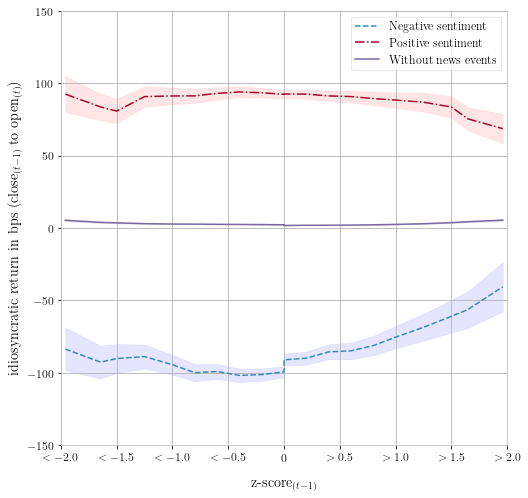

In [10]:
export_plot(table, 
            idiosyncratic=True, 
            show_standard_error=True, 
            yscale   = 150,
            export   = True, 
            title    = None, #'Fresh News',
            xlabel   = 'z-score$_{(t-1)}$',        
            ylabel   = f"idiosyncratic return in bps {ylabel_dict[return_period]}",           
            filename = f"idiosync_return_{return_period}__z_mo_to_mc_idiosync_2002_2020_{S.freshness}") 


# idiosync_return_mo_to_mo__z_mo_to_mc_idiosync_case34_2002_2020
# idiosync_return_mc_to_mo__z_mo_to_mc_idiosync_case34_2002_2020

In [211]:
# Write df to latex
filename = "idiosync_return_mo_to_mc__z_mo_to_mc_idiosync_2002_2020" 

with open(output_path+f"tables/{filename}.tex",'w') as tf:
    tf.write(export_table.round(3).to_latex()) 

## 2. Event Study

In [187]:
df_oc = pd.read_csv('./Data/event_data_abn_returns_oc_17_5h_z_val_idiosync_no_dupl_2002-2021_v2.csv', encoding='utf-8')
df_oc.Date = pd.to_datetime(df_oc.Date)
df_oc = df_oc.set_index(['Date', 'Ticker'])       

vix = pd.read_csv("C:/Users/Stefa/Documents/Uni/Projektassistenz/Financial Data/VIX.csv", encoding="utf-8")
vix.date = pd.to_datetime(vix.date)
vix = vix.set_index('date')

# Rename Columns
for col in list(df_oc.loc[:, 'return_t_Vo':'return_t_8c'].columns):
    df_oc = df_oc.rename(columns={col:re.sub(r'return_t(_|)', 't', col)})
    
for col in list(df_oc.loc[:, 'z_value_t_IIIo':'z_value_t_1c'].columns):
    df_oc = df_oc.rename(columns={col:re.sub(r'z_value_t(_|)', 'z_t', col)})      

Observations Case Neg. sentiment, neg. z-score: 5416
Observations Case Neg. sentiment, pos. z-score: 4430
Observations Case Pos. sentiment, pos. z-score: 5997
Observations Case Pos. sentiment, neg. z-score: 4963


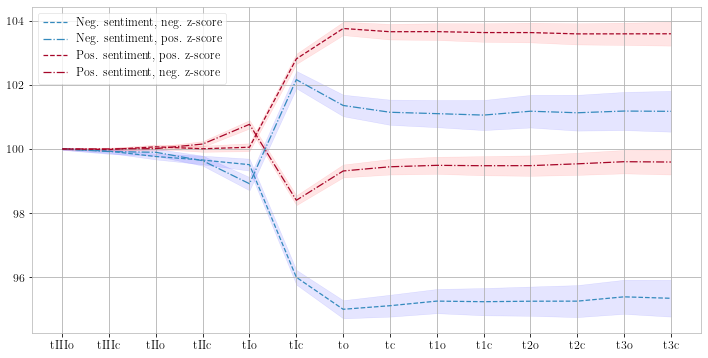

In [188]:
ex_post    = False  # show returns before the news event
export     = True  # save to file
zCrit      = 1.0
sCrit      = 0.45
vix_min    = 0
vix_max    = 200
freshness  = None                              
sel_topics = []#['topic_2']

period_start = datetime(2002,1,1)
period_end   = datetime(2019,12,31)

filename = f"event_study_oc_2002_2020_zCrit_{zCrit}_sCrit_{sCrit}"

cases = {}
cases['Neg. sentiment, neg. z-score'] = ((df_oc.Sentiment <= -sCrit) &
                                         (df_oc.z_tIc <= -zCrit))
cases['Neg. sentiment, pos. z-score'] = ((df_oc.Sentiment <= -sCrit) &
                                         (df_oc.z_tIc >= zCrit))
cases['Pos. sentiment, pos. z-score'] = ((df_oc.Sentiment >= sCrit) &
                                         (df_oc.z_tIc >= zCrit))
cases['Pos. sentiment, neg. z-score'] = ((df_oc.Sentiment >= sCrit) &
                                         (df_oc.z_tIc <= -zCrit))

# Linestyles
col0 = ["#348ABD", "#348ABD", "#A60628", "#A60628"]
col1 = ["b", "b", "r", "r"]
line = ["dashed", "dashdot", "dashed", "dashdot"]


def get_price(df, case, ex_post, period_start, period_end, vix_min, vix_max, freshness=None, sel_topics=[]):    
    if freshness != None:
        df = df.loc[df.freshness == freshness]

    if len(sel_topics) > 0:
        df = df.loc[df.loc[:, sel_topics].sum(axis=1) > 0]  
    
    if ex_post:
        df_sel = df.loc[cases[case], 'to':'t6c']
    else:
        df_sel = df.loc[cases[case], 'tIIIo':'t3c']
      
    ticks  = df_sel.columns
    
    # Filter for Volatility
    volatile_dates = vix.loc[((vix.vix >= vix_min) & (vix.vix < vix_max))].index
    df_sel = df_sel.loc[df_sel.index.get_level_values(0).isin(volatile_dates)]  
    
    # Filter Period
    df_sel = df_sel.loc[(((df_sel.index.get_level_values(0) >= period_start) & 
                          (df_sel.index.get_level_values(0) <= period_end)), slice(None)), :]
    
    
    n = df_sel.shape[0]
    mean = df_sel.mean()
    mean[0] = 0
    std  = df_sel.std()
    std_err = std/np.sqrt(n)
    t_value = mean/std_err
    
    p  = (100*(mean+1).cumprod().values).astype(np.float32)
    pu = (100*(mean+std_err+1).cumprod().values).astype(np.float32)
    pl = (100*(mean-std_err+1).cumprod().values).astype(np.float32)
    return p, pu, pl, n, ticks, t_value


t_values = {}
fig, ax = plt.subplots(figsize=(12,6))
for j, case in enumerate(cases):
    p, pu, pl, n, ticks, t_value = get_price(df_oc, case, ex_post, period_start, period_end, vix_min, vix_max, freshness, sel_topics)
    t_values[case] = t_value
    print(f'Observations Case {case}: {n}')
    ax.plot(ticks, p, linewidth=1.25, label=f"{case}", linestyle=line[j], color=col0[j])
    ax.fill_between(ticks, pu, pl, alpha=.1, color=col1[j]) 
plt.legend()
if export:
    plt.savefig(output_path+filename+'_'+datetime.now().strftime("%Hh%Mm%Ss")+'.pdf', dpi=100, facecolor='w', edgecolor='w', orientation='portrait')
plt.show()

In [275]:
pd.DataFrame.from_dict(t_values)

,"Neg. sentiment, neg. z-score","Neg. sentiment, pos. z-score","Pos. sentiment, pos. z-score","Pos. sentiment, neg. z-score"
tIIIo,0.000000,0.000000,0.000000,0.000000
tIIIc,-0.614591,-1.511686,-1.892453,-2.507623
tIIo,-2.442902,-0.063552,0.039820,2.790955
tIIc,-1.792526,0.466149,-2.416186,1.112701
tIo,-7.699701,-4.118571,4.452318,7.383513
tIc,-62.835293,47.794148,71.739022,-79.287615
to,-12.408238,-8.747305,15.624546,14.976067
tc,-0.719037,-3.447123,-0.733208,2.247443
t1o,3.197214,2.970220,-0.387783,2.485584
t1c,-0.499127,-2.639893,0.196070,-0.305530


#### Calculate with z-score intervals

In [28]:
class Strategy():    
    def __init__(self, return_period, freshness=None, sel_topics=[], use_abnormal_returns=True): 
        self.freshness  = freshness
        abn = '_abn' if use_abnormal_returns else '' 
        isfresh = '_freshness' if type(freshness) == str else ''
        self.event_data = pd.read_csv(f'./Data/event_data{abn}_returns_{return_period}_17_5h_z_val_idiosync_no_dupl{isfresh}_2002-2021_v2.csv', encoding='utf-8')
        self.event_data.Date = pd.to_datetime(self.event_data.Date)
        self.event_data = self.event_data.set_index(['Date', 'Ticker'])
        
        self.vix = pd.read_csv("C:/Users/Stefa/Documents/Uni/Projektassistenz/Financial Data/VIX.csv", encoding="utf-8")
        self.vix.date = pd.to_datetime(self.vix.date)
        self.vix = self.vix.set_index('date')
        

    def neg_sentiment(self, z0, z1, r='return_t'):                    
        # Negative news on day t and significantely negative z-value on day t-1 at market close ---------------
        neg_z = self.data.loc[self.filter_topics    &
                              self.filter_freshness & 
                              (self.data.Sentiment <= -self.barrier) &
                              (self.data.z_value  >= z0)            &
                              (self.data.z_value  <  z1), r].reset_index(drop=True)

        # Negative news on day t and significantely positive z-value on day t-1 at market close ---------------
        pos_z = self.data.loc[self.filter_topics    &
                              self.filter_freshness & 
                              (self.data.Sentiment <= -self.barrier) &
                              (self.data.z_value  >= z0)            &
                              (self.data.z_value  <  z1), r].reset_index(drop=True)       
        
        self.strategy_df = pd.concat([neg_z, pos_z], axis=1)
        self.strategy_df.columns = ['neg_z_score', 'pos_z_score']
        
        
        
    def pos_sentiment(self, z0, z1, r='return_t'):          
        # Positive news on day t and significantely negative z-value on day t-1 at market close --------------
        neg_z = self.data.loc[self.filter_topics    &
                              self.filter_freshness & 
                              (self.data.Sentiment >= self.barrier) &
                              (self.data.z_value   >= z0)           &
                              (self.data.z_value   <  z1), r].reset_index(drop=True)        
        
        # Positive news on day t and significantely positive z-value on day t-1 at market close --------------
        pos_z = self.data.loc[self.filter_topics    &
                              self.filter_freshness & 
                              (self.data.Sentiment >= self.barrier) &
                              (self.data.z_value  >= z0)           &
                              (self.data.z_value  <  z1), r].reset_index(drop=True)
        
        
        self.strategy_df = pd.concat([neg_z, pos_z], axis=1)
        self.strategy_df.columns = ['neg_z_score', 'pos_z_score']
        
        
       
    def z_score_no_news(self, z0, z1, r='return_t'):                  
        # Negative z-value on day t-1 at market close ---------------
        neg_z = self.data.loc[(self.data.z_value  >= z0) &
                              (self.data.z_value  <  z1) & (self.data.Sentiment.isna()), r].dropna().reset_index(drop=True)
        
        # Positive z-value on day t-1 at market close ---------------
        pos_z = self.data.loc[(self.data.z_value  >= z0) &
                              (self.data.z_value  <  z1) & (self.data.Sentiment.isna()), r].dropna().reset_index(drop=True)
        
        self.strategy_df = pd.concat([neg_z, pos_z], axis=1)
        self.strategy_df.columns = ['neg_z_score', 'pos_z_score']

                
        
    def fill_table(self, table, z0, z1, setting):
        table[setting].loc['mean',  z0] = self.strategy_df['pos_z_score'].dropna().mean()                
        table[setting].loc['sd',    z0] = self.strategy_df['pos_z_score'].dropna().std()                
        table[setting].loc['std_error',  z0] = self.strategy_df['pos_z_score'].dropna().std()/np.sqrt(self.strategy_df['pos_z_score'].dropna().shape[0])               
        table[setting].loc['t_value',    z0] = ttest_1samp(self.strategy_df['pos_z_score'].dropna(), 0)[0]             
        table[setting].loc['n_obs',      z0] = self.strategy_df['pos_z_score'].dropna().shape[0]               
        return table
        
        
        
    def calc_stats(self, period_start, period_end, settings, sel_topics, min_vix=0, max_vix=100, senti_limit=0.95,
                   z_scores = [0.0001, 0.2, 0.4, 0.6, 0.8, 1.0, 1.25, 1.5, 1.645, 1.96]):        
        
        self.barrier = senti_limit 
            
        # Filter Dates    
        self.data = self.event_data.loc[((self.event_data.index.get_level_values(0) > period_start) &
                                         (self.event_data.index.get_level_values(0) < period_end)), :]                
                
        # Filter for Volatility
        volatile_dates = self.vix.loc[((self.vix.vix >= min_vix) & (self.vix.vix < max_vix))].index
        self.data = self.data.loc[self.data.index.get_level_values(0).isin(volatile_dates)]   
                
        # Filter topics
        self.filter_topics = ((self.data.Sentiment.isna()) | 
                              ((self.data.topic_1 >= sel_topics['topic_1']) &
                               (self.data.topic_2 >= sel_topics['topic_2']) &
                               (self.data.topic_3 >= sel_topics['topic_3']) &
                               (self.data.topic_4 >= sel_topics['topic_4'])))
           
        # Filter freshness
        if type(self.freshness) == str:
            self.filter_freshness = (self.data.freshness == self.freshness)
        else:
            self.filter_freshness = self.data.freshness.isna()
            
        
        table = {}
        for setting in settings:
            table[setting] = pd.DataFrame(columns=z_scores)
            table[setting].index.name = 'Variable'
            
            for i in range(0, len(z_scores)-1):
                z0, z1 = z_scores[i], z_scores[i+1]
                if setting == 'neg_sentiment':
                    self.neg_sentiment(z0, z1)
                elif setting == 'pos_sentiment':
                    self.pos_sentiment(z0, z1)
                elif setting == 'z_score_no_news':
                    self.z_score_no_news(z0, z1)                         
                table = self.fill_table(table, z0, z1, setting)

        return table
    

S = Strategy(return_period = 'mc_to_mo',
             freshness  = 'stale',   # np.nan, 'fresh', 'stale'
             sel_topics = [], 
             use_abnormal_returns = True)  

In [29]:
table = S.calc_stats(period_start = datetime(2002,1,1), 
                     period_end   = datetime(2019,12,31),
                     min_vix      = 0,
                     max_vix      = 200,
                     senti_limit  = 0.45,           # Consider all news with a predicted sentiment >= senti_limit
                     sel_topics   = {'topic_1':0.0, 'topic_2':0.0, 'topic_3':0.0, 'topic_4':0.0},
                     settings     = ['neg_sentiment', 'pos_sentiment', 'z_score_no_news'],
                     z_scores     = [-10.0, -1.0, 1.0, 10.0])
                     #z_scores     = [-10.0, -2.0, -1.25, -0.75, -0.25, 0.25, 0.75, 1.25, 2.0, 10.0])

In [30]:
table['neg_sentiment']

,-10.0,-1.0,1.0,10.0
Variable,,,,
mean,-0.01197,-0.014274,-0.011978,NaN
sd,0.055448,0.042698,0.048777,NaN
std_error,0.001424,0.000612,0.001428,NaN
t_value,-8.408177,-23.304946,-8.38879,NaN
n_obs,1517,4860,1167,NaN


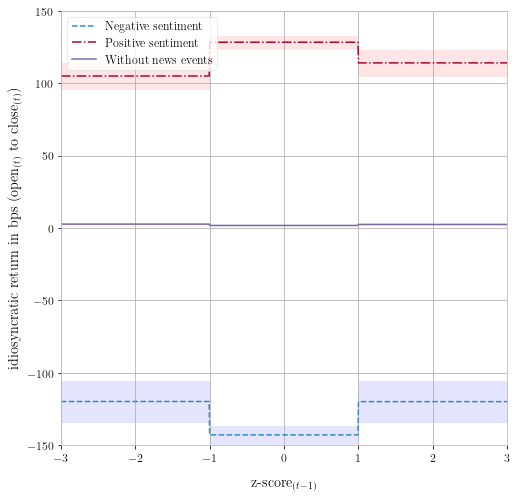

In [31]:
def cal_metric(metric='mean', setting='Conditional_1'):
    if setting == 'neg_sentiment':
        label = 'Negative sentiment'
    elif setting == 'pos_sentiment':
        label = 'Positive sentiment'
    else:
        label = re.sub(r'_', ' ', setting)
    var = table[setting].loc[metric]*10000
        
    return var, label


def export_plot(table, idiosyncratic=False, show_standard_error=True, 
                yscale=0.75, xscale=3, export=False, title=None,
                xlabel=None, ylabel=None,
                filename=datetime.now().strftime("%m%d%Y_%Hh%Mm%Ss")):    
    
    
    
    fontsize = 12
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': fontsize})
    rc('text', usetex=True)

    # linestyles
    col  = ["#348ABD", "#A60628", "#7A68A6"]
    line = ["dashed", "dashdot", "solid"]
    
    n = 1000
    x = np.linspace(-xscale, xscale, n)
    mean_0_y, mean_1_y, mean_2_y = np.zeros(n), np.zeros(n), np.zeros(n)
    std_error_0_y, std_error_1_y, std_error_2_y = np.zeros(n), np.zeros(n), np.zeros(n)

    axes  = {}
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    
    mean_0       = table['z_score_no_news'].loc['mean']*10000
    std_error_0  = table['z_score_no_news'].loc['std_error']*10000

    mean_1, label_1 = cal_metric(metric='mean',      setting='neg_sentiment')
    mean_2, label_2 = cal_metric(metric='mean',      setting='pos_sentiment')               
    std_error_1, _  = cal_metric(metric='std_error', setting='neg_sentiment')
    std_error_2, _  = cal_metric(metric='std_error', setting='pos_sentiment')
    
    for i in range(0, len(mean_0)-1):
        mean_0_y[(x >= mean_0.index[i]) & (x <= mean_0.index[i+1])] = mean_0.values[i]
        mean_1_y[(x >= mean_1.index[i]) & (x <= mean_1.index[i+1])] = mean_1.values[i]
        mean_2_y[(x >= mean_2.index[i]) & (x <= mean_2.index[i+1])] = mean_2.values[i]
        std_error_0_y[(x >= std_error_0.index[i]) & (x <= std_error_0.index[i+1])] = std_error_0.values[i]
        std_error_1_y[(x >= std_error_1.index[i]) & (x <= std_error_1.index[i+1])] = std_error_1.values[i]
        std_error_2_y[(x >= std_error_2.index[i]) & (x <= std_error_2.index[i+1])] = std_error_2.values[i]
    
    above_line_0 = (mean_0_y+std_error_0_y).astype(np.float32)
    below_line_0 = (mean_0_y-std_error_0_y).astype(np.float32)
    above_line_1 = (mean_1_y+std_error_1_y).astype(np.float32)
    below_line_1 = (mean_1_y-std_error_1_y).astype(np.float32)
    above_line_2 = (mean_2_y+std_error_2_y).astype(np.float32)
    below_line_2 = (mean_2_y-std_error_2_y).astype(np.float32)


    ax.plot(x, mean_1_y, label=label_1, linestyle='dashed', linewidth=1.5, color=col[0])
    ax.plot(x, mean_2_y, label=label_2, linestyle='dashdot', linewidth=1.5, color=col[1])
    ax.plot(x, mean_0_y, label='Without news events', linewidth=1.5, color=col[2])
    if show_standard_error:
        ax.fill_between(x, above_line_1, below_line_1, color='b', alpha=.1) 
        ax.fill_between(x, above_line_2, below_line_2, color='r', alpha=.1) 
        ax.fill_between(x, above_line_0, below_line_0, color='k', alpha=.1) 

    ax.set_xlabel('z-score', labelpad=15)
    #ax.set_ylabel('Avg. daily return (in %)')
    ax.set_ylim([-yscale,yscale])
    ax.set_xlim([-xscale,xscale])
    ax.legend()
    if title != None:
        ax.set_title(title)
    if xlabel != None:
        ax.set_xlabel(xlabel)
    if ylabel != None:
        ax.set_ylabel(ylabel)
    if export:
        plt.savefig(output_path+'plots/'+filename+'_'+datetime.now().strftime("%Hh%Mm%Ss")+'.pdf', bbox_inches='tight')
    plt.show()
    
    
export_plot(table, 
            idiosyncratic=True, 
            show_standard_error=True, 
            yscale   = 150,
            xscale   = 3,
            export   = True, 
            title    = None, #'Fresh News',
            xlabel   = 'z-score$_{(t-1)}$',        
            ylabel   = f"idiosyncratic return in bps {ylabel_dict[return_period]}",      
            filename = f"idiosync_return_{return_period}__z_mo_to_mc_idiosync_2002_2020_intervall_{S.freshness}") 